In [12]:
# imports needed for logistic regression setup
import copy
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc, ConfusionMatrixDisplay, recall_score, precision_score, f1_score


import matplotlib.pyplot as plt
%matplotlib inline

In [2]:

df = pd.read_csv('../data/merged_scaled_data.csv').dropna()

# Code below to display first 5 rows
df.head()


,Ticker Symbol,Period Ending,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,Cash and Cash Equivalents,...,Treasury Stock,For Year,Earnings Per Share,Estimated Shares Outstanding,Sector,Q avg to Q avg Price % Change,Y avg to Y avg Price % Change,Up or Down Q over Q,Up or Down Y over Y,"Buy, Hold, or Sell"
0,AAL,2012-12-31,-0.087332,-0.279488,-2.699804,-0.097271,-0.121872,0.050224,-0.207295,-0.160951,...,0.251674,-0.054840,-1.777818,-0.247668,Industrials,19.96,73.40,1.0,1.0,0.0
1,AAL,2013-12-31,0.167978,-0.036569,-3.703466,0.078609,-0.484173,0.731874,0.011270,0.113868,...,0.274503,-0.009835,-2.903089,-0.420072,Industrials,47.15,113.92,1.0,1.0,0.0
2,AAL,2014-12-31,0.126877,-0.162736,-0.314460,0.382400,-1.133419,1.257012,-0.137752,-0.018500,...,0.274503,0.035170,0.138130,0.135195,Industrials,18.72,16.37,1.0,1.0,0.0
3,AAL,2015-12-31,0.184981,0.801408,-1.049425,0.350422,-1.381651,0.847351,-0.227165,-0.240633,...,0.274503,0.080175,1.605961,0.086288,Industrials,-7.02,-15.51,0.0,0.0,2.0
4,AAP,2012-12-29,-0.175498,-0.029944,-0.116098,-0.061295,0.355921,-0.432351,-0.505338,-0.398983,...,0.272818,-0.054840,0.391067,-0.510034,Consumer Discretionary,4.66,11.51,1.0,1.0,0.0


In [3]:
df_one_hot = pd.get_dummies(df, columns=['Sector'])

X = df_one_hot.drop(['Ticker Symbol', 'Period Ending','Up or Down Q over Q', 'Up or Down Y over Y', 'Y avg to Y avg Price % Change', 'Q avg to Q avg Price % Change', 'Buy, Hold, or Sell'], axis='columns')
y = df_one_hot['Up or Down Y over Y'].values

# Splitting code here
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=0)


Recall: 0.6807017543859649 (what proportion of positives in population do we positively identify?)
Precision: 0.8117154811715481 (what proportion of the instances we labeled positive are actually positive?)
F-measure: 0.7404580152671756
Sensitivity: 0.6807017543859649 (What proportion of the positives do we correctly label?)
Specificity: 0.5588235294117647 (What proportion of the negatives do we correctly label?)


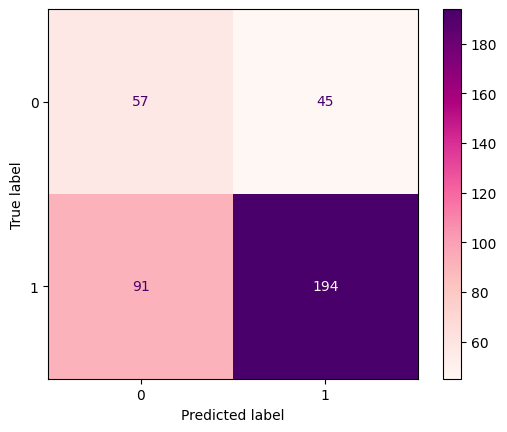

In [10]:
classifier_lr = LogisticRegression(penalty='l2', max_iter=10000, class_weight='balanced')
stocklr = classifier_lr.fit(Xtrain, ytrain)

up_or_down_predict = stocklr.predict(Xtest)
up_or_down_prob = stocklr.predict_proba(Xtest)

conf_matrix = confusion_matrix(ytest, up_or_down_predict)

tn, fp, fn, tp = confusion_matrix(ytest, up_or_down_predict).ravel()
specificity = tn / (tn+fp)

cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = [0, 1])

# need to quantify how the classifier is doing
print(f"Recall: {recall_score(ytest, up_or_down_predict)} (what proportion of positives in population do we positively identify?)")
print(f"Precision: {precision_score(ytest, up_or_down_predict)} (what proportion of the instances we labeled positive are actually positive?)")
print(f"F-measure: {f1_score(ytest, up_or_down_predict)}")
print(f"Sensitivity: {recall_score(ytest, up_or_down_predict)} (What proportion of the positives do we correctly label?)")
print(f"Specificity: {specificity} (What proportion of the negatives do we correctly label?)")

cm_display.plot(cmap='RdPu')
plt.show()


In [16]:
# now we try backwards step feature selection, removing one feature at a time
# we iterate until we only have one feature left
model_list = []
step = len(Xtrain.columns) - 1
while step > 0 :
    # Initialize RFE to pick the top steps out of the 86 features
    rfe = RFE(estimator=stocklr, n_features_to_select=step)

    # Fit RFE
    rfe.fit(Xtrain, ytrain)

    # Get the selected features
    selected_features = Xtrain.columns[rfe.support_]

    # train new model on reduced features
    classifier_lr = LogisticRegression(penalty='l2', max_iter=10000, class_weight='balanced')
    stocklr = classifier_lr.fit(Xtrain[selected_features], ytrain)

    up_or_down_predict = stocklr.predict(Xtest[selected_features])
    up_or_down_prob = stocklr.predict_proba(Xtest[selected_features])

    tn, fp, fn, tp = confusion_matrix(ytest, up_or_down_predict).ravel()
    specificity = tn / (tn+fp)
    recall = recall_score(ytest, up_or_down_predict)
    sensitivity_specificity = [recall, specificity]

    model_list.append([sensitivity_specificity, stocklr])
    
    step -= 1


KeyboardInterrupt: 